#### **Import Libraries**

In [1]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
import jax.numpy as jnp 

#### **Set Up Paths**

In [2]:
figures_folder = './../../../../instrumental_llms/figures/'

#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D  # For custom legend entries

rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-BoldItalic.ttf


#### **Process Data**

In [4]:
def process_dataframe(df):
    # Limit to the first 20 observations
    df = df.head(20)
    
    # Drop rows where any column has an absolute value greater than 2
    df = df[df.apply(lambda x: (x.abs() <= 10).all(), axis=1)]
    return df

#### **Parameters**

In [5]:
version = 4
noise = False

#### **Read In Data**

#### **Plot**

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


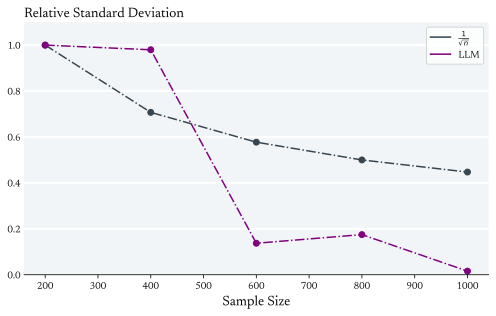

In [6]:
sample_sizes = [200, 400, 600, 800, 1000]
df = {}
for sample_size in sample_sizes:
    df[sample_size] = pd.read_csv(f'./../../../toy-data/exp2/results/llms_{version}_{sample_size}_{noise}.csv')
    df[sample_size]  = process_dataframe( df[sample_size])
    

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Relative Standard Deviation', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

ys = [np.std(df[sample_size])/np.std(df[200]) for sample_size in sample_sizes]
c = ys[0]*np.sqrt(sample_sizes[0])
ys2 = [c/np.sqrt(sample_size) for sample_size in sample_sizes]

# Plotting with markers and line styles
plt.plot(sample_sizes, ys2, linestyle='-.', marker='o', color='#36454F')
plt.plot(sample_sizes, ys, linestyle='-.', marker='o', color='purple')

# Creating custom legend handles
legend_handles = [
    Line2D([0], [0], color='#36454F', linestyle='-', label=r'$\frac{1}{\sqrt{n}}$'),  # Custom handle for the first plot
    Line2D([0], [0], color='purple', linestyle='-', label='LLM')  # Custom handle for the second plot
]

# Adding labels, title, and custom legend to the plot
plt.ylabel('')
plt.xlabel('Sample Size', size=14)
plt.ylim(0., 1.1)
plt.legend(handles=legend_handles)


fig.savefig(figures_folder + 'exp2_llm_empirical_convergence.png')
plt.show()

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


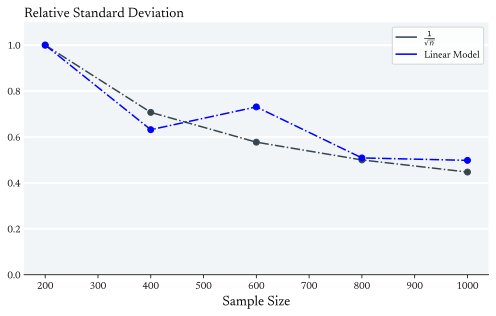

In [7]:
sample_sizes = [200, 400, 600, 800, 1000]
df = {}
for sample_size in sample_sizes:
    df[sample_size] = pd.read_csv(f'./../../../toy-data/exp2/results/linear_{version}_{sample_size}_{noise}.csv')
    df[sample_size]  = process_dataframe( df[sample_size])
    

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Relative Standard Deviation', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

ys = [np.std(df[sample_size])/np.std(df[200]) for sample_size in sample_sizes]
c = ys[0]*np.sqrt(sample_sizes[0])
ys2 = [c/np.sqrt(sample_size) for sample_size in sample_sizes]

# Plotting with markers and line styles
plt.plot(sample_sizes, ys2, linestyle='-.', marker='o', color='#36454F')
plt.plot(sample_sizes, ys, linestyle='-.', marker='o', color='blue')

# Creating custom legend handles
legend_handles = [
    Line2D([0], [0], color='#36454F', linestyle='-', label=r'$\frac{1}{\sqrt{n}}$'),  # Custom handle for the first plot
    Line2D([0], [0], color='blue', linestyle='-', label='Linear Model')  # Custom handle for the second plot
]

# Adding labels, title, and custom legend to the plot
plt.ylabel('')
plt.xlabel('Sample Size', size=14)
plt.ylim(0., 1.1)
plt.legend(handles=legend_handles)


fig.savefig(figures_folder + 'exp2_linear_empirical_convergence.png')
plt.show()